In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 

In [2]:
import subprocess
from pprint import pprint

In [3]:
cmd = [f'g++ -o bin/kFromN kFromN.cpp']
p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
cout, cerr = p.communicate()
print(cout.decode(), cerr.decode())

In [16]:
#setup config
config_data = {}

config_data['k'] = 10
config_data['rep_num'] = 1000
config_data['output'] = 'data/output.csv'
config_data['exp_num'] = 100

### Построим график зависимости вероятности события от n и k.  

In [12]:
data = {'n' : [], 'prob_mean' : [], 'prob_std' : []}

for n in range(1, 50):
    data['n'].append(n)
    prob = []
    for rep in range(1, 10):
        k = config_data['k']
        rep_num = config_data['rep_num']
        output = config_data['output']

        cmd = ['bin/kFromN {} {} {} {}'.format(n, config_data['k'], config_data['rep_num'], config_data['output'])]
        p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        cout, cerr = p.communicate()
        with open(config_data['output'], 'r') as outfile:
            result = float(outfile.read())
        prob.append(result)
    data['prob_mean'].append(np.mean(prob))
    data['prob_std'].append(np.std(prob))

df = pd.DataFrame(data)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


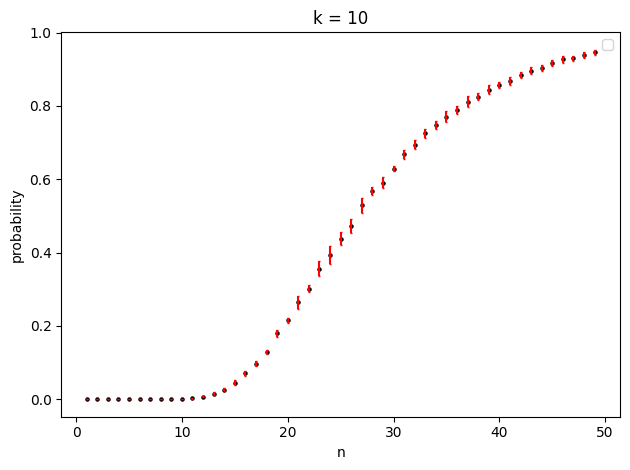

In [13]:
fig, ax = plt.subplots()

ax.errorbar(df['n'], df['prob_mean'], df['prob_std'], ecolor='red', color='black', ls="None", capsize=1)
ax.scatter(df['n'], df['prob_mean'], s=5, color='black')
ax.set_xlabel('n')
ax.set_ylabel('probability')
ax.set_title(f'k = {k}')
fig.tight_layout()
ax.legend()

### Найдем зависимость ошибки от размера выборки при фиксированных параметрах
В качестве параметров возьмем n = 25, k = 10

In [17]:
n = 25
k = 10
raw_data = {'rep_num' : [], 'error' : []}

for rep_num in range(1, 1000):

    for i in range(config_data['exp_num']):
        cmd = ['bin/kFromN {} {} {} {}'.format(n, config_data['k'], rep_num, config_data['output'])]
        p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        cout, cerr = p.communicate()
        with open(config_data['output'], 'r') as outfile:
            result = float(outfile.read())
        prob.append(result)

    raw_data['rep_num'].append(rep_num)
    raw_data['error'].append(np.std(prob))




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


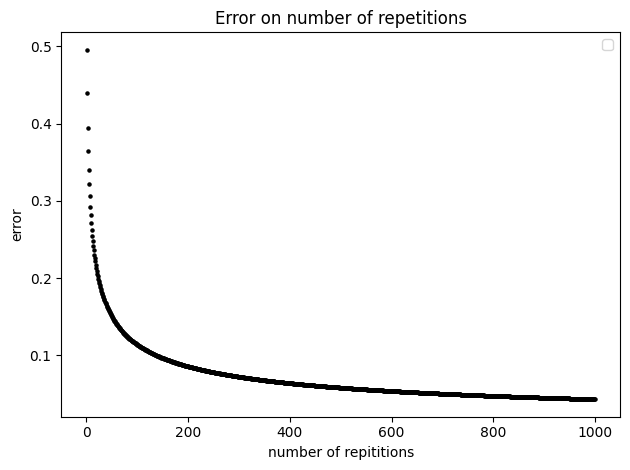

In [36]:
df_err = pd.DataFrame(raw_data)

fig, ax = plt.subplots()

ax.scatter(df_err['rep_num'], df_err['error'], s=5, color='black')
ax.set_xlabel('number of repititions')
ax.set_ylabel('error')
ax.set_title(f'Error on number of repetitions')
fig.tight_layout()
ax.legend()

### Попытаемся выяснить, что это за функция


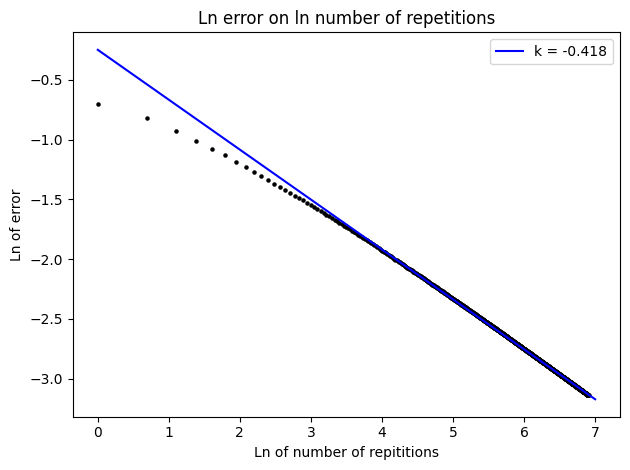

In [37]:
df_err = pd.DataFrame(raw_data)

fig, ax = plt.subplots()

df_err['log_error'] = np.log(df_err['error'])
df_err['log_rep_num'] = np.log(df_err['rep_num'])
df_err_cut = df_err[df_err['log_rep_num'] > 3]

def foo(x, a, b):
    return a * x + b

from scipy.optimize import curve_fit
popt, pcov = curve_fit(foo, df_err_cut['log_rep_num'], df_err_cut['log_error'])

ax.plot(np.linspace(0, 7, 100), foo(np.linspace(0, 7, 100), *popt), color='blue', label='k = {}'.format(round(popt[0], 3)))
ax.scatter(df_err['log_rep_num'], df_err['log_error'], s=5, color='black')
ax.set_xlabel('Ln of number of repititions')
ax.set_ylabel('Ln of error')
ax.set_title(f'Ln error on ln number of repetitions')
fig.tight_layout()
ax.legend()

### Анализ показал, что зависимость ошибки от мощности выборки может быть выражена формулой:
$$Error \sim 1 / \sqrt{N}$$